In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/DL"

/content/drive/MyDrive/DL


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from keras.applications import VGG16, ResNet50, DenseNet201
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [ ]:
image_path = 'Flickr8k/Images'

In [ ]:
data = pd.read_csv("Flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [ ]:
# Hàm đọc hình ảnh này dùng để phục vụ trực quan hóa
def readImage(path,img_size=224):
    # Load ảnh từ đường dẫn path với màu RGB và kích thước được chỉ định
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    # Chuyển ảnh thành mảng numpy
    img = img_to_array(img)
    # Chuẩn hóa các giá trị pixel trong khoảng từ 0 đến 1 để chuẩn hóa dữ liệu
    img = img/255.

    return img
# Hàm này dùng để hiển thị hình ảnh cùng với mô tả của chúng trong một lưới.
def display_images(temp_df):
    # Đặt lại chỉ số của DataFrame để đảm bảo việc lặp chính xác
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20)) # Tạo một hình vẽ mới với kích thước cụ thể
    n = 0 # Khởi tạo một biến đếm
    # Lặp qua 15 mục để hiển thị
    for i in range(15):
        n+=1 # Tăng biến đếm
        plt.subplot(5 , 5, n)  # Tạo subplot trong lưới 5 hàng và 5 cột
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3) # Điều chỉnh khoảng cách giữa các subplot
        image = readImage(f"Flickr8k/Images/{temp_df.image[i]}") # Tải và hiển thị một hình ảnh bằng cách sử dụng hàm readImage
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20))) # Đặt tiêu đề của subplot với đoạn mô tả, tự động xuống dòng sau mỗi 20 ký tự
        plt.axis("off")

# **Visualization**
- Images và Captions tương ứng

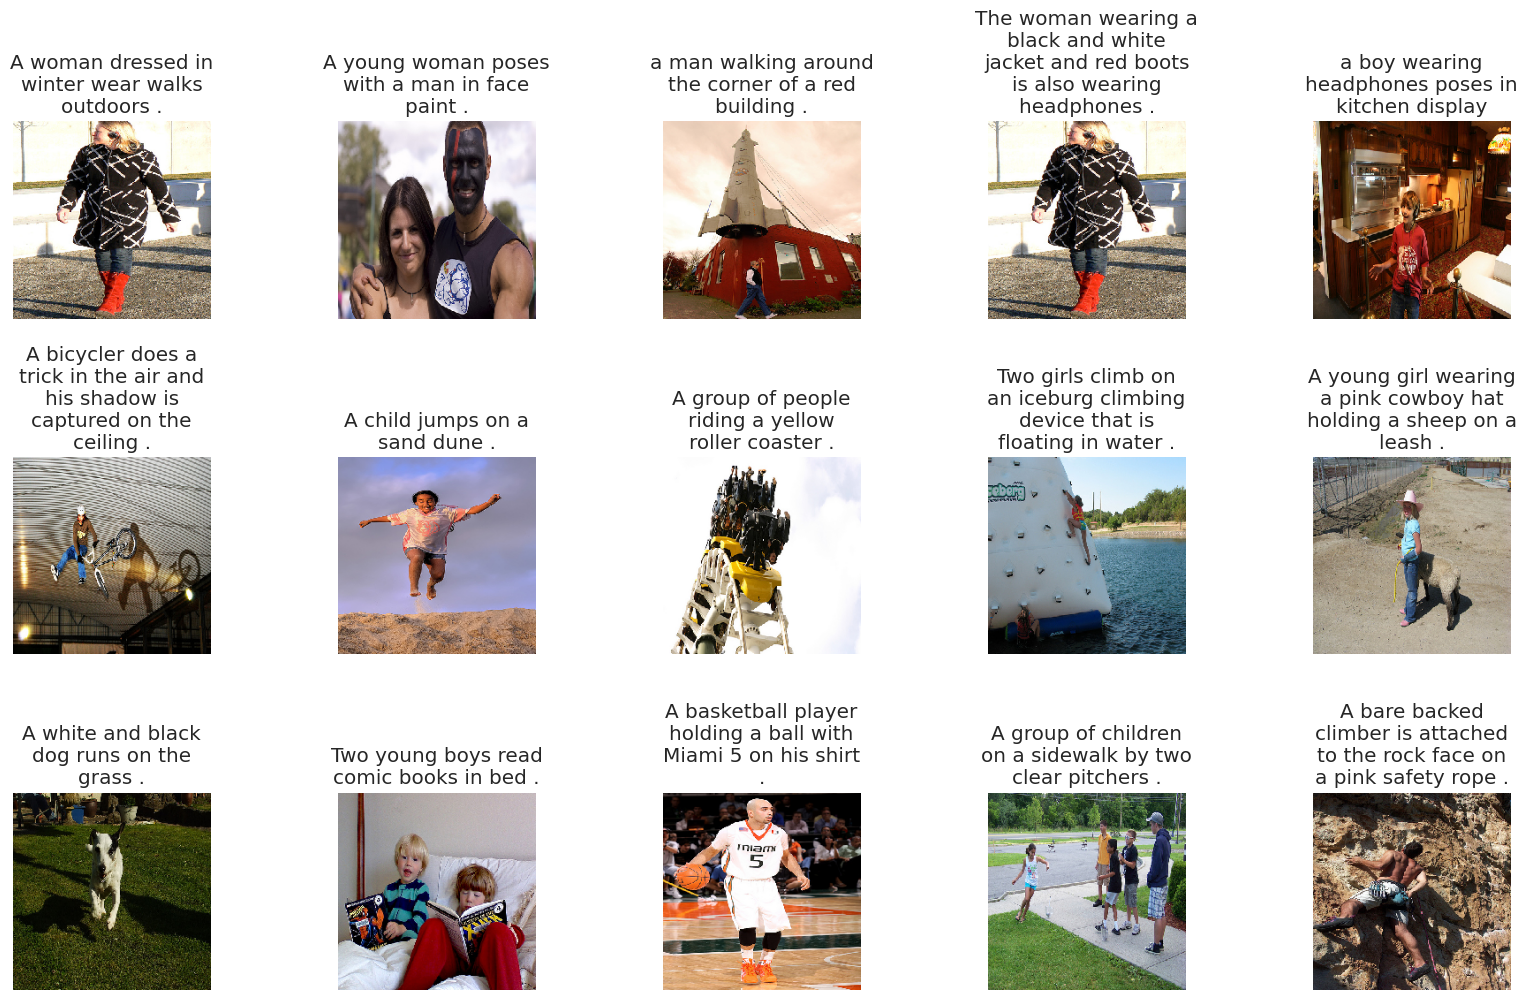

In [ ]:
display_images(data.sample(15))

# **Các Bước Tiền Xử lý Caption**
- Chuyển các câu thành chữ thường
- Loại bỏ ký tự đặc biệt và số có mặt trong văn bản
- Loại bỏ các khoảng trắng dư thừa
- Loại bỏ các ký tự đơn
- Thêm thẻ bắt đầu và thẻ kết thúc vào các câu để chỉ ra điểm bắt đầu và kết thúc của một câu

In [ ]:
# Hàm này thực hiện tiền xử lý dữ liệu văn bản
def text_preprocessing(data):
    # Chuyển các ký tự trong cột 'caption' về chữ thường
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    # Loại bỏ các ký tự không phải là chữ cái trong cột 'caption'
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    # Loại bỏ các khoảng trắng dư thừa trong cột 'caption'
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    # Loại bỏ các từ có độ dài là 1 trong cột 'caption'
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    # Thêm "startseq" vào đầu và "endseq" vào cuối mỗi câu trong cột 'caption'
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Tokenization

In [ ]:
# Tạo một tokenizer để mã hóa văn bản thành các chuỗi số
tokenizer = Tokenizer()
# Sử dụng tokenizer để xây dựng từ điển từ vựng từ các câu mô tả (captions)
tokenizer.fit_on_texts(captions)
# Xác định kích thước từ vựng
vocab_size = len(tokenizer.word_index) + 1
# Xác định độ dài lớn nhất của câu mô tả trong tập dữ liệu
max_length = max(len(caption.split()) for caption in captions)
# Lấy danh sách các ảnh duy nhất trong dữ liệu
images = data['image'].unique().tolist()
# Đếm số lượng hình ảnh duy nhất trong danh sách đó và gán vào biến nimages
nimages = len(images)
# Phân chia tập hình ảnh thành tập huấn luyện và tập validation
split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

# Tạo tập dữ liệu huấn luyện và tập dữ liệu kiểm tra dựa trên các hình ảnh đã chia
# Tạo tập train bằng cách lọc các dòng trong data mà cột 'image' của chúng có giá trị nằm trong danh sách train_images
train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]
# Đặt lại chỉ số của DataFrame để sắp xếp lại và truy xuất dễ dàng hơn
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

# Chuyển đổi câu mô tả thành chuỗi số tương ứng sử dụng tokenizer
tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

# **Trích xuất đặc trưng hình ảnh**

Cách 1

In [ ]:
# Khởi tạo một mô hình DenseNet201
model = DenseNet201()
# Tạo một mô hình mới (fe) chỉ chứa các layers của DenseNet201 từ đầu đến layer thứ hai từ cuối, để trích xuất đặc trưng.
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224 # Kích thước mà các hình ảnh sẽ được resize đến.
features = {}

# Một vòng lặp được sử dụng để xử lý từng hình ảnh trong danh sách các hình ảnh duy nhất trong dữ liệu
for image in tqdm(data['image'].unique().tolist()):
    # Load hình ảnh, thay đổi kích thước về img_size x img_size.
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    # Chuyển hình ảnh thành mảng numpy và chuẩn hóa giá trị pixel về khoảng [0, 1].
    img = img_to_array(img)
    img = img/255.
    # Mở rộng chiều để phù hợp với đầu vào của mô hình.
    img = np.expand_dims(img,axis=0)
    # Sử dụng mô hình fe để dự đoán đặc trưng của hình ảnh.
    feature = fe.predict(img, verbose=0)
    # Lưu trữ đặc trưng của từng hình ảnh trong một từ điển với khóa là tên của hình ảnh.
    features[image] = feature

100%|██████████| 8091/8091 [1:41:33<00:00,  1.33it/s]


In [ ]:
#import pickle
# Lưu features
#with open('features.pkl', 'wb') as f:
#    pickle.dump(features, f)

In [ ]:
import pickle

# Đọc features từ tệp
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

Cách 2

In [ ]:
# Khai báo class CustomDataGenerator kế thừa từ Sequence, một class trong thư viện keras để tạo generator cho dữ liệu.
class CustomDataGenerator(Sequence):
    # Khởi tạo hàm constructor với các tham số được truyền vào.
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):
        # Lưu trữ các tham số như dataframe, tên cột dữ liệu đầu vào và đầu ra, thư mục, kích thước batch, tokenizer, v.v.
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
    # Hàm được gọi sau mỗi epoch trong quá trình huấn luyện.
    def on_epoch_end(self):
        # Nếu được yêu cầu (shuffle=True), trộn dữ liệu trong dataframe ngẫu nhiên sau mỗi epoch.
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    # Hàm trả về số lượng batch trong mỗi epoch.
    def __len__(self):
        # Số lượng batch được tính dựa trên kích thước batch và số lượng dữ liệu có sẵn.
        return self.n // self.batch_size

    # Hàm trả về batch dữ liệu tương ứng với index.
    def __getitem__(self,index):
        # Lấy ra một batch từ dataframe dựa trên index.
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        # Gọi hàm __get_data() để xử lý dữ liệu trong batch.
        X1, X2, y = self.__get_data(batch)
        ## Trả về dữ liệu input (X1, X2) và output (y) của batch.
        return (X1, X2), y
    # Hàm xử lý dữ liệu trong một batch.
    def __get_data(self,batch):
        # Khởi tạo các danh sách để lưu trữ dữ liệu.
        X1, X2, y = list(), list(), list()
        # Lấy danh sách các ảnh từ cột dữ liệu đầu vào trong batch.
        images = batch[self.X_col].tolist()
        for image in images:
            # Lấy đặc trưng của ảnh từ features dictionary.
            feature = self.features[image][0]
            # Lấy danh sách các chú thích tương ứng với ảnh từ cột dữ liệu đầu ra trong batch.
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                # Chuyển các chú thích thành chuỗi số bằng tokenizer
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    # Tạo các chuỗi input và output từ chuỗi số.
                    in_seq, out_seq = seq[:i], seq[i]
                    # Padding các chuỗi input để có cùng độ dài.
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    # Chuyển output thành dạng one-hot encoding. Cho phù hợp với hàm loss
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    # Thêm dữ liệu vào các danh sách đã khởi tạo trước đó.
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        # Trả về dữ liệu input (X1, X2) và output (y) của batch sau khi xử lý.
        return X1, X2, y
#train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
from keras.layers import Embedding

# Load các trọng số GloVe
glove_path = 'glove.6B.200d.txt'  # Đường dẫn đến file GloVe đã tải
embedding_dim = 200  # Kích thước của các vector embedding GloVe

embeddings_index = {}
with open(glove_path, encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Chuẩn bị ma trận embedding
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# **Modelling**

In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(200, activation='relu')(input1)
img_features_reshaped = Reshape((1, 200), input_shape=(200,))(img_features)

#sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

#Thiết lập lớp embedding trong mô hình Keras
sentence_features = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length,
                            trainable=False)(input2)  # Đặt trainable=False để không cập nhật trọng số embedding trong quá trình đào tạo
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(200)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)

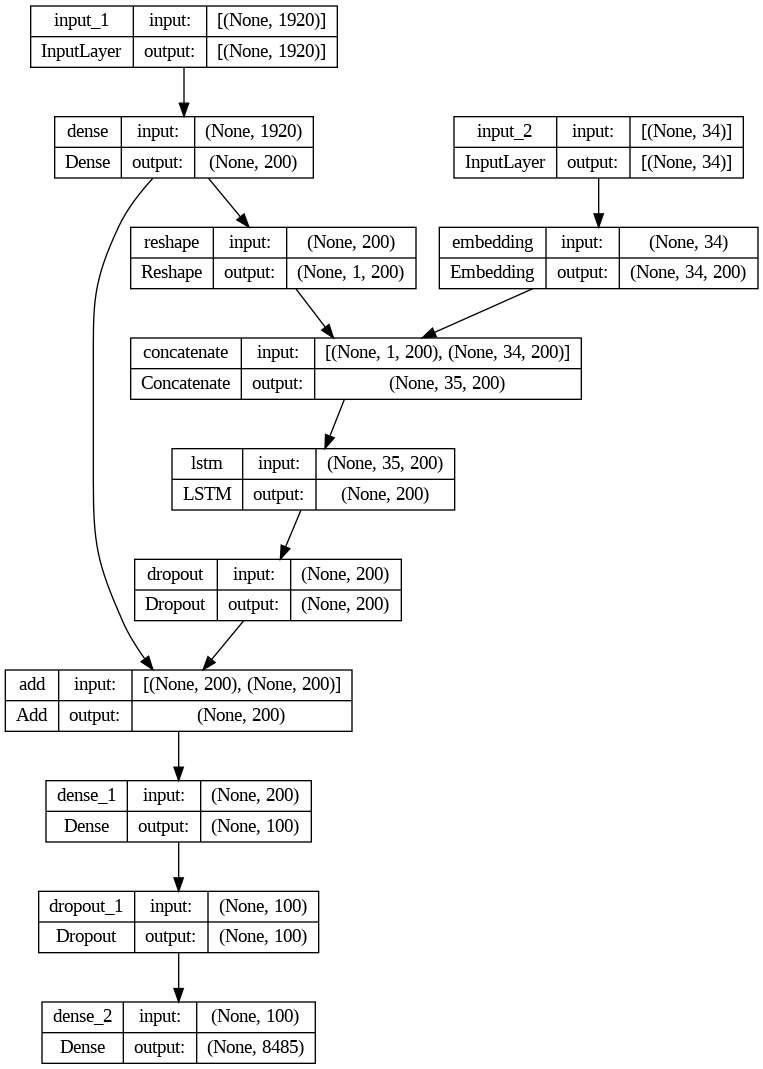

In [ ]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(caption_model, to_file=dot_img_file, show_shapes=True)

In [ ]:
caption_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1920)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 200)                  384200    ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 200)               0         ['dense[0][0]']               
                                                                                              

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
callbacks = [
    TensorBoard(
        log_dir='./logs',
        histogram_freq=10,
        profile_batch=0,
        write_graph=True,
        write_images=False,
        update_freq="epoch"),
    ModelCheckpoint(
        'checkpoint_weights_model_3.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-8,
        patience=5,
        restore_best_weights=True,
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',
        min_delta=1e-8,
        factor=0.2,
        patience=3,
        verbose=1)
]
callbacks_list = callbacks

## **Trainning**

In [ ]:
caption_model.load_weights('checkpoint_weights_model_3.h5')

In [ ]:
from keras.optimizers.legacy import Adam

learning_rate = 0.002
caption_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=learning_rate))
history = caption_model.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator,
        callbacks=callbacks_list)

Epoch 1/5
537/537 [==============================] - ETA: 0s - loss: 3.8375
Epoch 1: val_loss did not improve from 3.67338
537/537 [==============================] - 104s 89ms/step - loss: 3.8375 - val_loss: 3.7847 - lr: 0.0020


KeyboardInterrupt: 

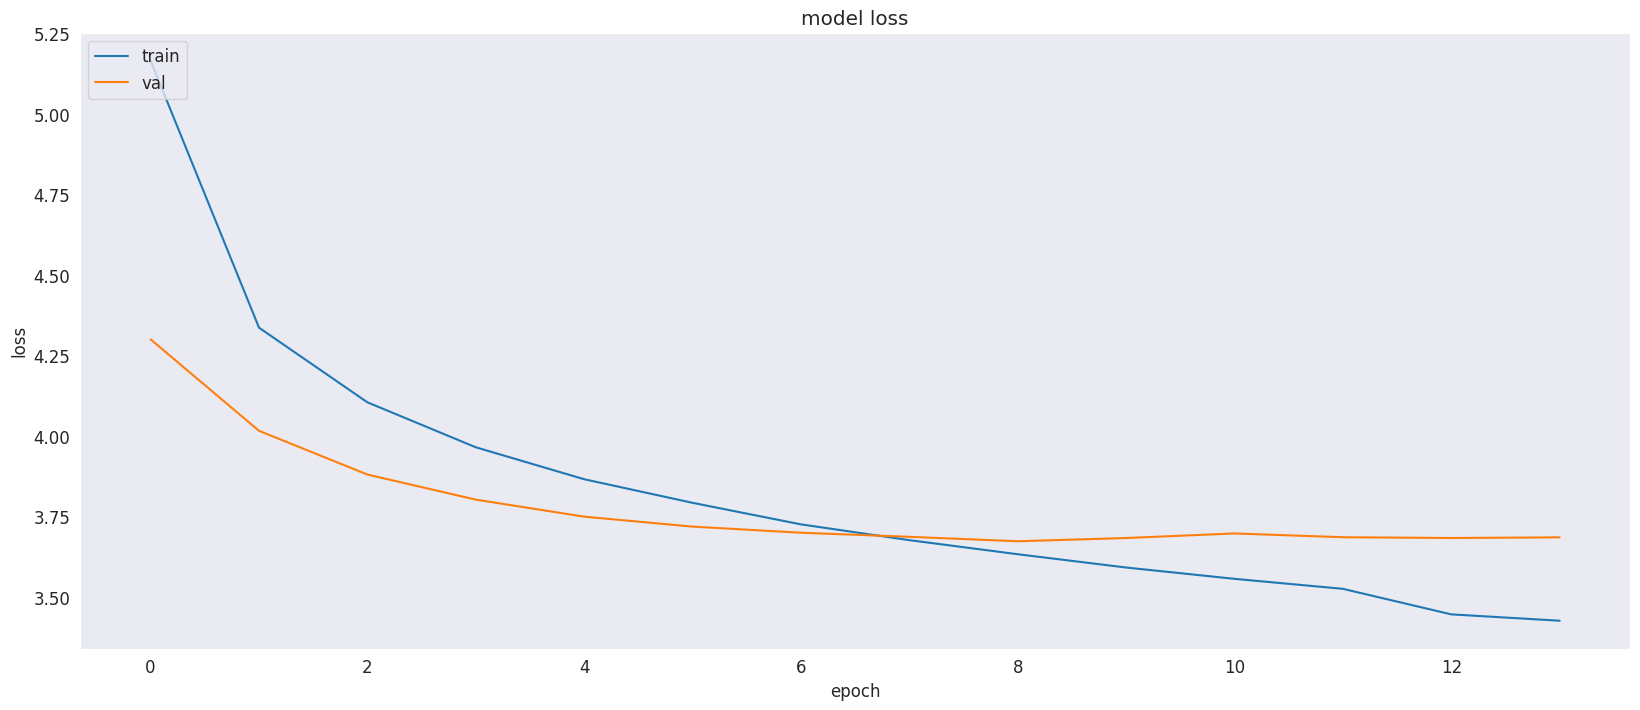

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 19ms/step


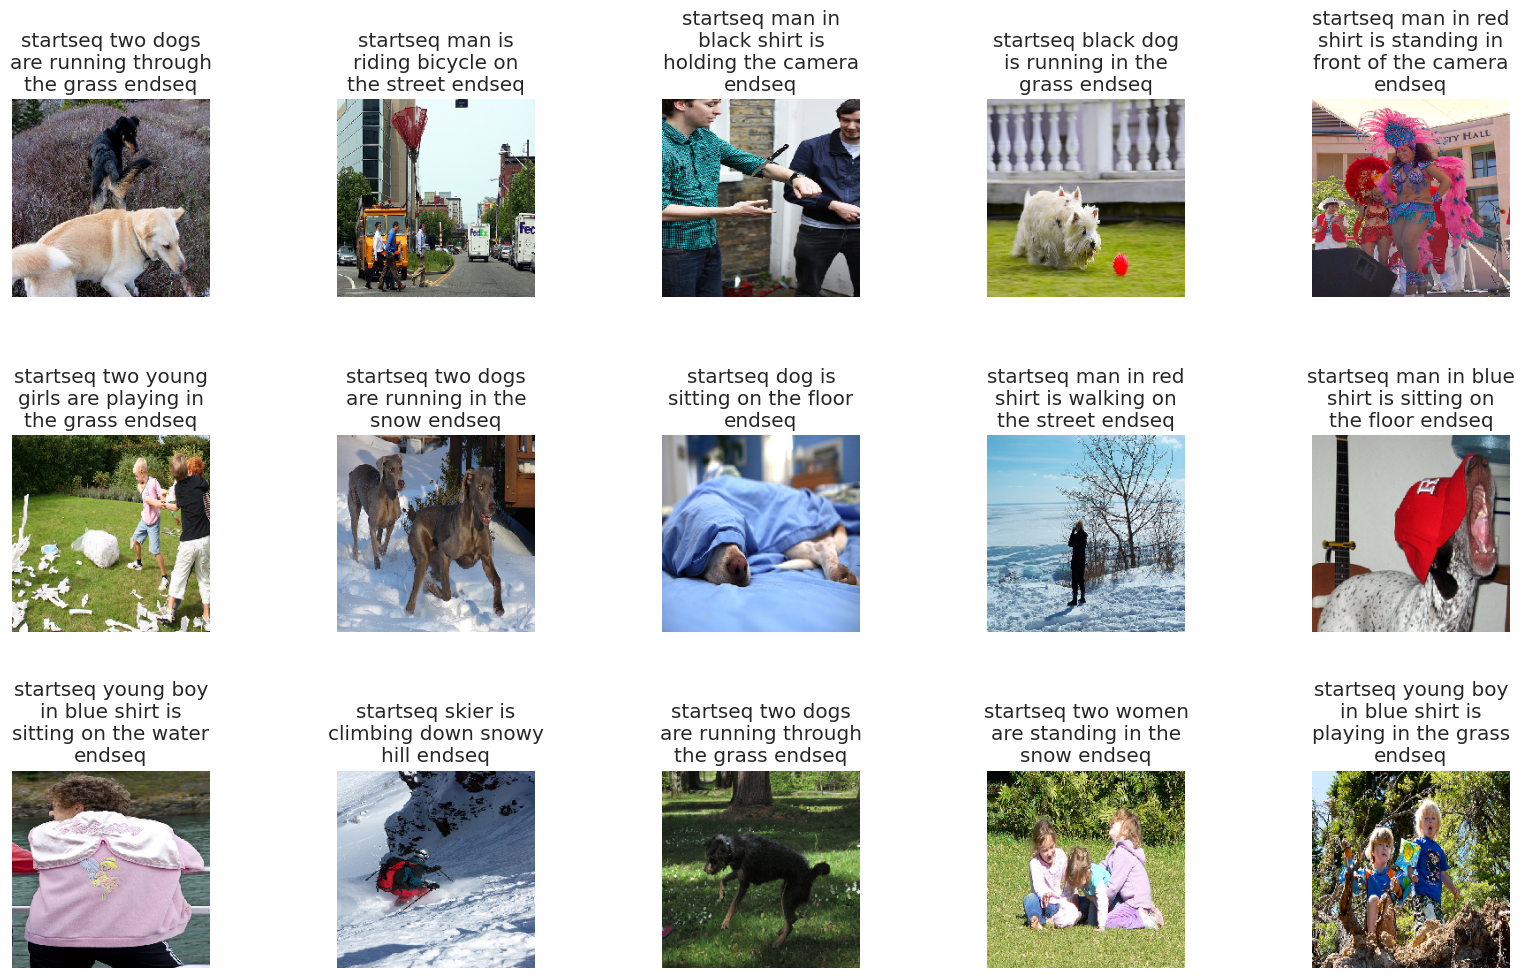

In [ ]:
display_images(samples)

In [ ]:
import numpy as np
from collections import Counter
import statistics

# hàm tạo ra n-gram
def generate_ngrams(sentence, n):
    # Chuyển câu thành danh sách các từ
    words = sentence.lower().split(' ')
    # Khởi tạo danh sách n-gram
    ngrams = []
    # Duyệt qua danh sách từ
    for i in range(len(words) - n + 1):
        # Thêm n-gram vào danh sách
        ngrams.append(" ".join(words[i:i+n]))
    return ngrams

# hàm đánh giá độ khớp của câu mẫu và câu do mô hình dự đoán
def precision_score(ref_ngram, can_ngram):
    if len(can_ngram) == 0 or len(ref_ngram) == 0:
        print("Error: câu rỗng")
        return None
    # Đếm số lượng mỗi n-gram
    ref_counts = Counter(ref_ngram)
    can_counts = Counter(can_ngram)

    # Tính số lượng n-gram trong câu dịch khớp với câu mẫu
    match_counts = sum(min(ref_counts[ngram], can_counts[ngram]) for ngram in can_counts)
    p = match_counts / max(len(can_ngram), 1)
    return p

def bleu(candidate, references, N=1):
    # Xử lý riêng từng cặp câu candidate - reference (references gồm nhiều câu mẫu)
    average = []
    for reference in references:
        lenc = len(candidate.split())
        lenr = len(reference.split())
        BP = 1 if lenc >= lenr else np.exp(1 - (lenr / lenc))
        gram_score = 0
        # Xử lý riêng từng số lượng gram N (uni, bi, tri,...)
        for i in range(1, N + 1):
            can_ngram = generate_ngrams(candidate, i)
            ref_ngram = generate_ngrams(reference, i)
            pn = precision_score(ref_ngram, can_ngram)
            gram_score += np.log(pn)
        ref_score = BP * np.exp(gram_score)
        average.append(ref_score)
    return statistics.mean(average)

# Sử dụng hàm
# c = "The girl is sitting on a stone bench"
# r = ["The girl is sitting in the park on a bench", "The girl in red is sitting on a bench"]
# print(bleu(c, r, 1))

avg = []
file_name = test["image"].unique()
test_captions = test["caption"].values


for f in file_name:
    ref = test.loc[test['image'] == f]["caption"].values
    pre = predict_caption(caption_model, f, tokenizer, max_length, features)
    avg.append(bleu(pre, ref, 1))

print(statistics.mean(avg))

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step
0.31605883121784845
